Classifier Training and Evaluation

Train 5 different classifiers on YAMNet embeddings:
1. Logistic Regression (baseline)
2. Random Forest
3. Gradient Boosting (XGBoost)
4. Support Vector Machine (SVM)
5. Multi-Layer Perceptron (MLP)

Each classifier is evaluated on validation set and saved for later comparison.

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, precision_score, 
                             recall_score, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')



In [8]:
FEATURES_DIR = '../data/approach1/features'
MODELS_DIR = '../models/models_approach1'
RESULTS_DIR = '../results/results_approach1'
RANDOM_SEED = 42
TRAIN_VAL_SIZE = 0.8   # 80% train+val, 20% held-out test
VAL_SIZE = 0.125       # 12.5% of train+val → ~10% overall
N_FOLDS = 3

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

np.random.seed(RANDOM_SEED)

In [9]:
# LOAD FEATURES AND LABELS

print("\nLOADING DATA")

X = np.load(os.path.join(FEATURES_DIR, 'yamnet_features.npy'))
y = np.load(os.path.join(FEATURES_DIR, 'yamnet_labels.npy'))
metadata = pd.read_csv(os.path.join(FEATURES_DIR, 'yamnet_features_metadata.csv'))

print(f"\nLoaded features: {X.shape}")
print(f"Loaded labels: {y.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
classes = label_encoder.classes_

print(f"\nClasses ({len(classes)}): {', '.join(classes)}")
print(f"\n{'Category':<20} {'Count':<10} {'Percentage':<10}")
print("-"*40)
for idx, cls in enumerate(classes):
    count = np.sum(y_encoded == idx)
    percentage = count / len(y_encoded) * 100
    print(f"{cls:<20} {count:<10} {percentage:>6.2f}%")



LOADING DATA

Loaded features: (7100, 1024)
Loaded labels: (7100,)

Classes (5): Alarm_Clock, Car_Horn, Glass_Breaking, Gunshot, Siren

Category             Count      Percentage
----------------------------------------
Alarm_Clock          1296        18.25%
Car_Horn             1480        20.85%
Glass_Breaking       1216        17.13%
Gunshot              1536        21.63%
Siren                1572        22.14%


In [22]:
# TRAIN-VALIDATION-TEST SPLIT

# Step 1: Isolate test set (never used here)
X_train_val, X_test, y_train_val_str, y_test_str, y_train_val_enc, y_test_enc = train_test_split(
    X, y, y_encoded,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_encoded
)

# Step 2: Split train_val → train + val
X_train, X_val, y_train_str, y_val_str, y_train_enc, y_val_enc = train_test_split(
    X_train_val, y_train_val_str, y_train_val_enc,
    test_size=0.125,
    random_state=RANDOM_SEED,
    stratify=y_train_val_enc
)

print(f"Training:   {X_train.shape[0]:,} samples")
print(f"Validation: {X_val.shape[0]:,} samples")
print(f"Test:       {X_test.shape[0]:,} samples")

# Encode for training
y_train_encoded = y_train_enc
y_val_encoded = y_val_enc
y_test_encoded = y_test_enc  # for internal use

# SCALE FEATURES
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


joblib.dump(scaler, os.path.join(MODELS_DIR, 'feature_scaler.pkl'))
joblib.dump(label_encoder, os.path.join(MODELS_DIR, 'label_encoder.pkl'))



Training:   4,970 samples
Validation: 710 samples
Test:       1,420 samples


['../models/models_approach1\\label_encoder.pkl']

In [11]:
# DEFINE CLASSIFIERS AND HYPERPARAMETERS

classifiers = {
    'Logistic_Regression': {
        'model': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, n_jobs=-1),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        },
        'scaled': True
    },
    'Random_Forest': {
        'model': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt']
        },
        'scaled': False
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(
            random_state=RANDOM_SEED,
            n_jobs=-1,
            objective='multi:softprob',
            eval_metric='mlogloss'
        ),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        },
        'scaled': False
    },
    'SVM': {
        'model': SVC(random_state=RANDOM_SEED, probability=True, cache_size=1000),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf'],
            'gamma': ['scale', 'auto']
        },
        'scaled': True
    },
    'MLP': {
        'model': MLPClassifier(
            random_state=RANDOM_SEED,
            max_iter=500,
            early_stopping=True,
            n_iter_no_change=15
        ),
        'params': {
            'hidden_layer_sizes': [(256,), (512,), (256, 128)],
            'activation': ['relu'],
            'alpha': [0.0001, 0.001],
            'learning_rate': ['adaptive']
        },
        'scaled': True
    }
}

print("\nClassifiers to train:")
for idx, name in enumerate(classifiers.keys(), 1):
    config = classifiers[name]
    n_combinations = np.prod([len(v) for v in config['params'].values()])
    print(f"  {idx}. {name:<25} {n_combinations:>3} hyperparameter combinations")




Classifiers to train:
  1. Logistic_Regression         5 hyperparameter combinations
  2. Random_Forest              16 hyperparameter combinations
  3. XGBoost                    72 hyperparameter combinations
  4. SVM                         6 hyperparameter combinations
  5. MLP                         6 hyperparameter combinations


In [12]:
# TRAINING LOOP WITH GRID SEARCH

results = {}
best_models = {}

for name, config in classifiers.items():
    print(f"\nTraining: {name}")
    X_tr = X_train_scaled if config['scaled'] else X_train
    X_va = X_val_scaled if config['scaled'] else X_val

    grid = GridSearchCV(
        config['model'], config['params'],
        cv=StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED),
        scoring='f1_macro', n_jobs=-1, verbose=0
    )
    grid.fit(X_tr, y_train)

    model = grid.best_estimator_
    best_models[name] = model

    # Validation predictions
    y_val_pred = model.predict(X_va)
    y_val_proba = model.predict_proba(X_va)

    val_metrics = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred, average='macro'),
        'recall': recall_score(y_val, y_val_pred, average='macro'),
        'f1_macro': f1_score(y_val, y_val_pred, average='macro'),
        'f1_weighted': f1_score(y_val, y_val_pred, average='weighted')
    }

    results[name] = {
        'best_params': grid.best_params_,
        'cv_f1': grid.best_score_,
        'val_metrics': val_metrics,
        'val_pred': y_val_pred,
        'val_proba': y_val_proba
    }

    print(f"  CV F1: {grid.best_score_:.4f} | Val F1: {val_metrics['f1_macro']:.4f}")
    joblib.dump(model, os.path.join(MODELS_DIR, f'{name.lower()}_model.pkl'))


Training: Logistic_Regression
  CV F1: 0.9002 | Val F1: 0.9191

Training: Random_Forest
  CV F1: 0.9021 | Val F1: 0.9213

Training: XGBoost
  CV F1: 0.9125 | Val F1: 0.9257

Training: SVM
  CV F1: 0.8936 | Val F1: 0.9209

Training: MLP
  CV F1: 0.9018 | Val F1: 0.9250


In [13]:
print("\nMODEL COMPARISON (Validation F1)")
print("="*80)

comparison = []
for name, r in results.items():
    comparison.append({
        'Model': name,
        'CV F1': round(r['cv_f1'], 4),
        'Val Acc': round(r['val_metrics']['accuracy'], 4),
        'Val F1': round(r['val_metrics']['f1_macro'], 4),
        'Val Precision': round(r['val_metrics']['precision'], 4),
        'Val Recall': round(r['val_metrics']['recall'], 4)
    })

comp_df = pd.DataFrame(comparison).sort_values('Val F1', ascending=False)
print("\n" + comp_df.to_string(index=False))

comp_path = os.path.join(RESULTS_DIR, 'model_comparison.csv')
comp_df.to_csv(comp_path, index=False)
print(f"\nSaved comparison: {comp_path}")


MODEL COMPARISON (Validation F1)

              Model  CV F1  Val Acc  Val F1  Val Precision  Val Recall
            XGBoost 0.9125   0.9254  0.9257         0.9270      0.9251
                MLP 0.9018   0.9254  0.9250         0.9254      0.9249
      Random_Forest 0.9021   0.9211  0.9213         0.9221      0.9213
                SVM 0.8936   0.9211  0.9209         0.9217      0.9208
Logistic_Regression 0.9002   0.9183  0.9191         0.9191      0.9193

Saved comparison: ../results/results_approach1\model_comparison.csv


Saved validation confusion matrices: ../results/results_approach1\val_confusion_matrices.png


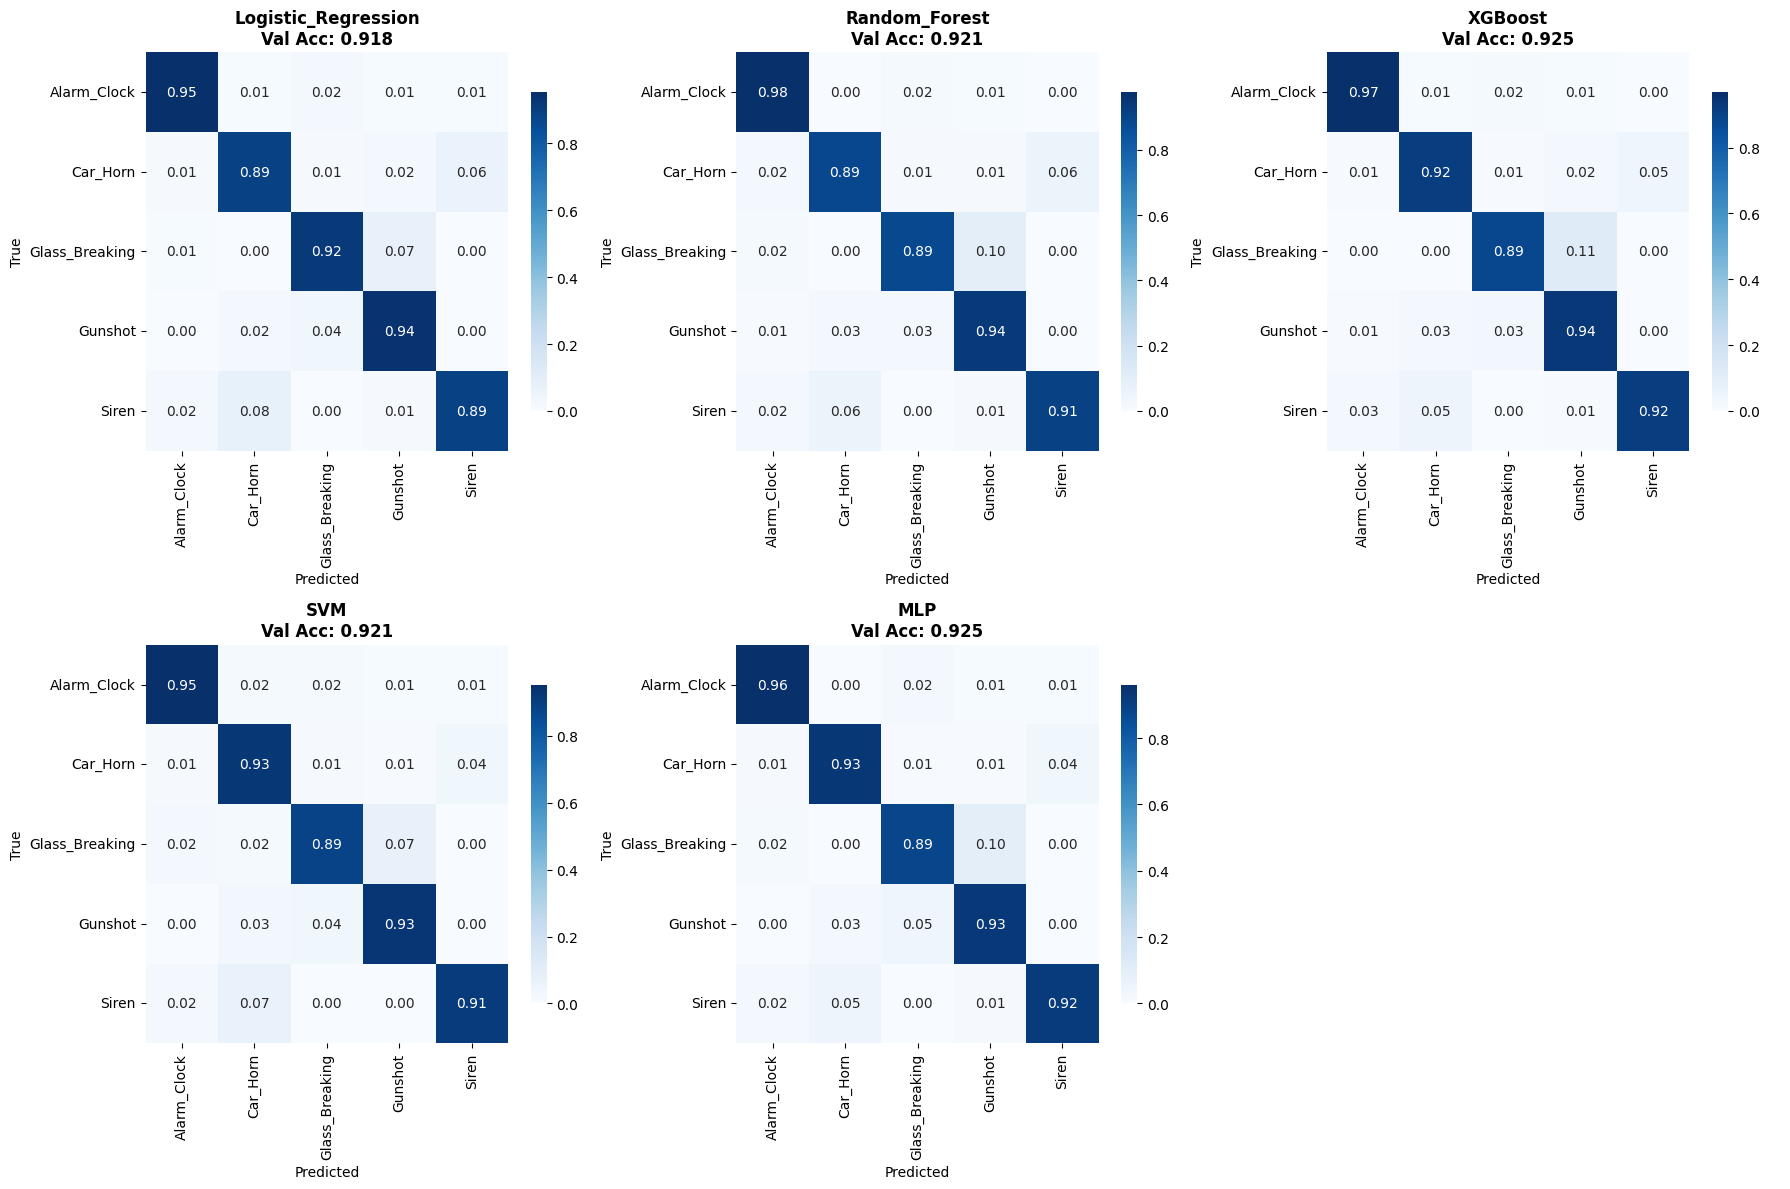

In [14]:
# CONFUSION MATRIX (Validation Only)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, r) in enumerate(results.items()):
    cm = confusion_matrix(y_val, r['val_pred'])
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes, ax=axes[idx],
                cbar_kws={'shrink': 0.8})
    acc = r['val_metrics']['accuracy']
    axes[idx].set_title(f'{name}\nVal Acc: {acc:.3f}', fontweight='bold')
    axes[idx].set_ylabel('True')
    axes[idx].set_xlabel('Predicted')

if len(results) < 6:
    for j in range(len(results), 6):
        axes[j].axis('off')

plt.tight_layout()
cm_path = os.path.join(RESULTS_DIR, 'val_confusion_matrices.png')
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"Saved validation confusion matrices: {cm_path}")
plt.show()

In [24]:
# TEST SET
test_dir = '../data/approach1/test_set'
os.makedirs(test_dir, exist_ok=True)
np.save(os.path.join(test_dir, 'X_test.npy'), X_test)
np.save(os.path.join(test_dir, 'y_test.npy'), y_test_str) 
print(f"Test set saved (string labels): {test_dir}")

# SAVE TEST SET: frame_path LIST (for raw audio reconstruction)
test_dir = '../data/approach1/test_set'
os.makedirs(test_dir, exist_ok=True)

# Get indices of test set in original metadata
test_indices = np.where(np.isin(np.arange(len(y)), np.where(np.isin(y, y_test_str))[0]))[0]

# Save frame_path directly from metadata using test set mask
original_indices = np.arange(len(y))
_, test_idx = train_test_split(
    original_indices, test_size=0.2, random_state=RANDOM_SEED, stratify=y_encoded
)

test_frame_paths = metadata.iloc[test_idx]['frame_path'].values
np.save(os.path.join(test_dir, 'test_frame_paths.npy'), test_frame_paths)
print(f"Test frame paths saved: {len(test_frame_paths)} files")

# TRAIN/VAL SET
train_dir = '../data/approach1/train_val'
os.makedirs(train_dir, exist_ok=True)
np.save(os.path.join(train_dir, 'X_train.npy'), X_train)
np.save(os.path.join(train_dir, 'y_train.npy'), y_train_str)  # ← STRINGS!
np.save(os.path.join(train_dir, 'X_val.npy'), X_val)
np.save(os.path.join(train_dir, 'y_val.npy'), y_val_str)
print(f"Train/Val set saved (string labels): {train_dir}")

Test set saved (string labels): ../data/approach1/test_set
Test frame paths saved: 1420 files
Train/Val set saved (string labels): ../data/approach1/train_val


In [19]:
# FINAL SUMMARY
print("\nTRAINING COMPLETE (Test Set Untouched)")

best = comp_df.iloc[0]
print(f"  Best Model: {best['Model']}")
print(f"  Validation F1: {best['Val F1']}")
print(f"  All models saved: {MODELS_DIR}")
print(f"  Test set preserved for final comparison")


TRAINING COMPLETE (Test Set Untouched)
  Best Model: XGBoost
  Validation F1: 0.9257
  All models saved: ../models/models_approach1
  Test set preserved for final comparison
